In [1]:
import os
import numpy
import pandas
import random
import zipfile
import datetime
import tensorflow
import matplotlib.pyplot
import tensorflow_datasets

from PIL import Image
from google.colab import files

In [2]:
datetime.datetime.now()

datetime.datetime(2023, 9, 8, 4, 23, 50, 731136)

In [3]:
# Acute Lymphoblastic Leukemia  Cell Diagnosis System
# Base Model | Variation - 01

# import the kaggle credential file for authentication
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thlurte","key":"7f158b4e3df15e1877248d67653f1084"}'}

In [4]:
# Necessary file changes
!rm -r ~/.kaggle # In case if /.kaggle exists remove it and its contents
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
# Download the dataset directly from Kaggle
!kaggle datasets download -d andrewmvd/leukemia-classification

 98% 853M/867M [00:08<00:00, 54.7MB/s]
100% 867M/867M [00:08<00:00, 105MB/s] 


In [6]:
# Extract the contents of the dataset using zipfile module
zip_file = zipfile.ZipFile('/content/leukemia-classification.zip','r')
zip_file.extractall('/content')
zip_file.close()

> Since the contents of `testing_data` and `validation_data` does not contain any structured labels, we have decided not to use them.

> Meanwhile three folds inside the `training_data` will be used in the following way :
- `fold_0` : Training Data
- `fold_1` : Testing Data
- `fold_2` : Validation Data

In [7]:
# Respective directories instantiated as string variables for furture use
training_data_dir='/content/C-NMC_Leukemia/training_data/fold_0'
testing_data_dir='/content/C-NMC_Leukemia/training_data/fold_1'
validation_data_dir='/content/C-NMC_Leukemia/training_data/fold_2'

In [8]:
# available lables
labels=['all','hem']

In [9]:
# Visualize images in the dataset
def random_img_finder(url,typ):
  category=random.choice(typ)
  return category,random.choice(list(os.walk(f'{url}/{category}'))[0][2])

def img_plotter(url,nrows,ncols):
  fig,ax=matplotlib.pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(20,12))
  for i in range(ncols):
    for j in range(nrows):
      cat,img=random_img_finder(url,labels)
      ax[i][j].imshow(numpy.asarray(Image.open(f'{url}/{cat}/{img}')))
      ax[i][j].set_title(f'Category : {cat}')
      ax[i][j].axis('off')

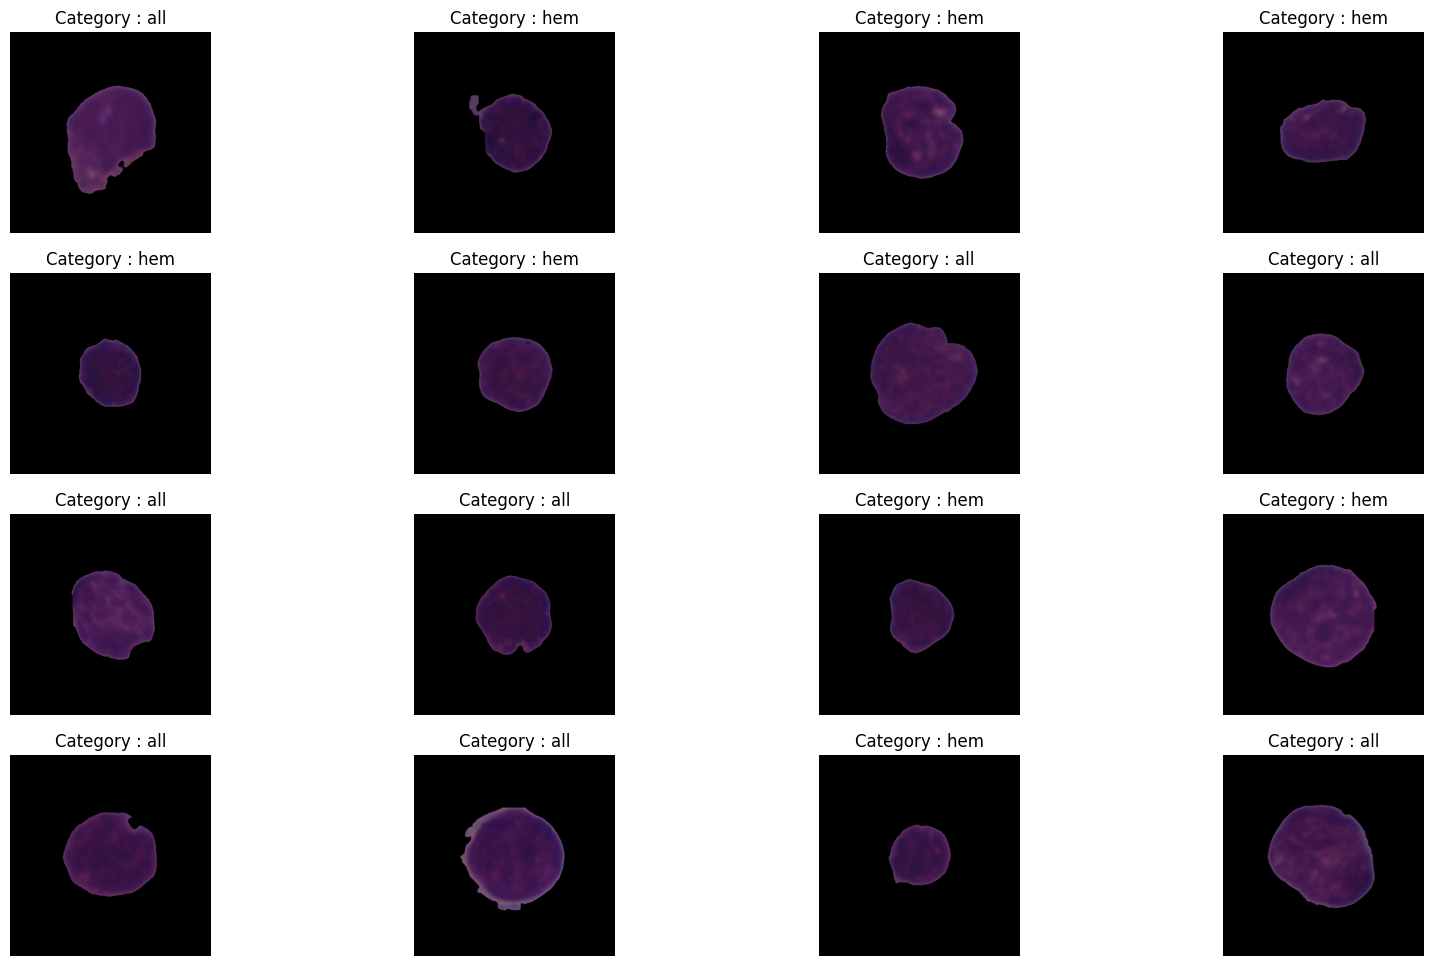

In [10]:
img_plotter(training_data_dir,4,4)

In [11]:
# Describe the quantitative aspect of the dataset
dataset_contents={
    # Train Data all
    'training_data_all':[i for i in os.walk('/content/C-NMC_Leukemia/training_data/fold_0/all')][0][2],
    # Train Data hem
    'training_data_hem':[i for i in os.walk('/content/C-NMC_Leukemia/training_data/fold_0/hem')][0][2],
    # Testing Data all
    'testing_data_all':[i for i in os.walk('/content/C-NMC_Leukemia/training_data/fold_1/all')][0][2],
    # Testing Data hem
    'testing_data_hem':[i for i in os.walk('/content/C-NMC_Leukemia/training_data/fold_1/hem')][0][2],
    # Validation Data all
    'validation_data_all':[i for i in os.walk('/content/C-NMC_Leukemia/training_data/fold_2/all')][0][2],
    # Validation Data hem
    'validation_data_hem':[i for i in os.walk('/content/C-NMC_Leukemia/training_data/fold_2/hem')][0][2],
    }
## Major Elements of the database
print('Images Avaialble in Training Data : ',len(dataset_contents['training_data_all'])+len(dataset_contents['training_data_hem']))
print('Division of Training set into all and hem would be like :',len(dataset_contents['training_data_all']),'and',len(dataset_contents['training_data_hem']))
print()
print()
print('Images Avaialble in Testing Data : ',len(dataset_contents['testing_data_all'])+len(dataset_contents['testing_data_hem']))
print('Division of Testing set into all and hem would be like :',len(dataset_contents['testing_data_all']),'and',len(dataset_contents['testing_data_hem']))
print()
print()
print('Images Avaialble in Validation Data : ',len(dataset_contents['validation_data_all'])+len(dataset_contents['validation_data_hem']))
print('Division of Validation set into all and hem would be like :',len(dataset_contents['validation_data_all']),'and',len(dataset_contents['validation_data_hem']))

Images Avaialble in Training Data :  3527
Division of Training set into all and hem would be like : 2397 and 1130


Images Avaialble in Testing Data :  3581
Division of Testing set into all and hem would be like : 2418 and 1163


Images Avaialble in Validation Data :  3553
Division of Validation set into all and hem would be like : 2457 and 1096


In [13]:
# parameters
batch_size=32
img_height=180
img_width=180
train_ds=tensorflow.keras.utils.image_dataset_from_directory(
  training_data_dir,
  label_mode='binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3527 files belonging to 2 classes.


In [14]:
test_ds=tensorflow.keras.utils.image_dataset_from_directory(
    testing_data_dir,
    label_mode='binary',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3581 files belonging to 2 classes.


In [15]:
validation_ds=tensorflow.keras.utils.image_dataset_from_directory(
    validation_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3553 files belonging to 2 classes.


In [16]:
# Classes avaialble
train_ds.class_names

['all', 'hem']

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 1)


Standardize the data by normalizing it to be in the range [0,1]

In [18]:
AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
num_classes = 2

model = tensorflow.keras.Sequential([
  tensorflow.keras.layers.Rescaling(1./255),
  tensorflow.keras.layers.Conv2D(32, 3, activation='relu'),
  tensorflow.keras.layers.MaxPooling2D(),
  tensorflow.keras.layers.Conv2D(32, 3, activation='relu'),
  tensorflow.keras.layers.MaxPooling2D(),
  tensorflow.keras.layers.Conv2D(32, 3, activation='relu'),
  tensorflow.keras.layers.MaxPooling2D(),
  tensorflow.keras.layers.Flatten(),
  tensorflow.keras.layers.Dense(128, activation='relu'),
  tensorflow.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model for binary classification
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss for two classes
              metrics=['accuracy'])


In [23]:
history=model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=10
)

Epoch 1/10
111/111 [==============================] - 38s 231ms/step - loss: 0.4637 - accuracy: 0.8046 - val_loss: 0.4255 - val_accuracy: 0.8364
Epoch 2/10
111/111 [==============================] - 4s 32ms/step - loss: 0.4403 - accuracy: 0.8171 - val_loss: 0.4205 - val_accuracy: 0.8327
Epoch 3/10
111/111 [==============================] - 3s 30ms/step - loss: 0.4272 - accuracy: 0.8234 - val_loss: 0.4284 - val_accuracy: 0.8347
Epoch 4/10
111/111 [==============================] - 3s 30ms/step - loss: 0.4147 - accuracy: 0.8259 - val_loss: 0.4053 - val_accuracy: 0.8344
Epoch 5/10
111/111 [==============================] - 4s 33ms/step - loss: 0.4018 - accuracy: 0.8330 - val_loss: 0.4000 - val_accuracy: 0.8392
Epoch 6/10
111/111 [==============================] - 3s 31ms/step - loss: 0.3760 - accuracy: 0.8455 - val_loss: 0.4014 - val_accuracy: 0.8431
Epoch 7/10
111/111 [==============================] - 3s 30ms/step - loss: 0.3440 - accuracy: 0.8523 - val_loss: 0.4380 - val_accuracy: 0.83

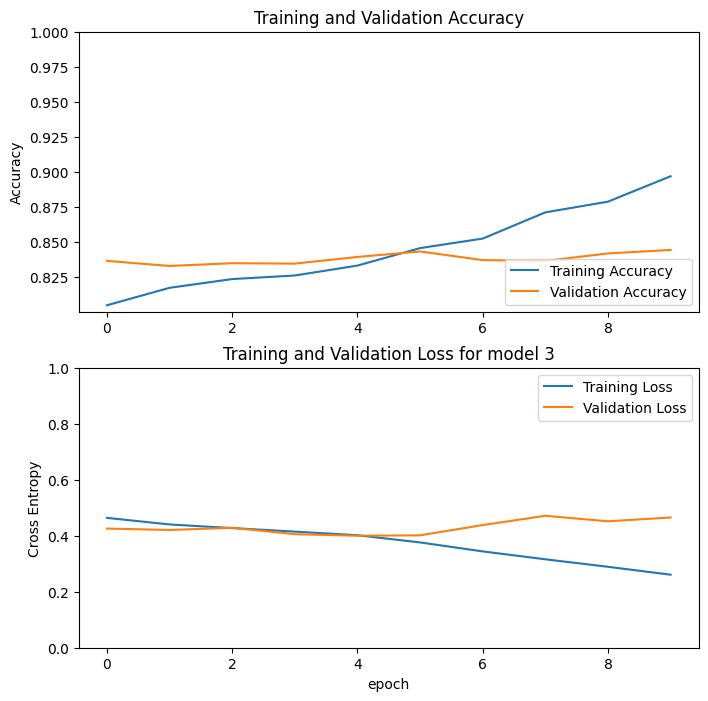

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

matplotlib.pyplot.figure(figsize=(8, 8))
matplotlib.pyplot.subplot(2, 1, 1)
matplotlib.pyplot.plot(acc, label='Training Accuracy')
matplotlib.pyplot.plot(val_acc, label='Validation Accuracy')
matplotlib.pyplot.legend(loc='lower right')
matplotlib.pyplot.ylabel('Accuracy')
matplotlib.pyplot.ylim([min(matplotlib.pyplot.ylim()),1])
matplotlib.pyplot.title('Training and Validation Accuracy')

matplotlib.pyplot.subplot(2, 1, 2)
matplotlib.pyplot.plot(loss, label='Training Loss')
matplotlib.pyplot.plot(val_loss, label='Validation Loss')
matplotlib.pyplot.legend(loc='upper right')
matplotlib.pyplot.ylabel('Cross Entropy')
matplotlib.pyplot.ylim([0,1.0])
matplotlib.pyplot.title('Training and Validation Loss for model 3')
matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.show()

In [25]:
model.save('/content/wb')

In [26]:
!zip -r /content/wb.zip /content/wb

  adding: content/wb/ (stored 0%)
  adding: content/wb/fingerprint.pb (stored 0%)
  adding: content/wb/keras_metadata.pb (deflated 91%)
  adding: content/wb/saved_model.pb (deflated 89%)
  adding: content/wb/assets/ (stored 0%)
  adding: content/wb/variables/ (stored 0%)
  adding: content/wb/variables/variables.index (deflated 64%)
  adding: content/wb/variables/variables.data-00000-of-00001 (deflated 20%)
